In [7]:
# Import the libraries/files we want to run
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import importlib
# local files (stuff we wrote)
import DataProcessing
import ProjectMap
import BaseModel
import DualInputModel
import Analysis
from scripts.DataProcessing import adaptive_segmentation

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
#This allows changes to be reflected whenever we make them
importlib.reload(DataProcessing)
importlib.reload(BaseModel)
importlib.reload(DualInputModel)

GPU is available


<module 'DualInputModel' from '/mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts/DualInputModel.py'>

In [8]:
# Get the directory layout of the project
PROJECT_MAP= ProjectMap.ProjectMap()
print(PROJECT_MAP)

Root: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project
Scripts: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts
Data: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/data


In [9]:
# This gives us a reusable function to load data
# Odds are this is not how we will actually handle the data, it's just easy to do this for the base model
#Added in logic to bring in Plant ID dataset from - https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets?resource=download

training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)


----------
Analyzing Training Data
----------


----------
Class distribution is the following:
{'aloevera': 799, 'banana': 799, 'bilimbi': 799, 'cantaloupe': 799, 'cassava': 799, 'coconut': 799, 'corn': 799, 'cucumber': 800, 'curcuma': 799, 'eggplant': 799, 'galangal': 799, 'ginger': 799, 'guava': 799, 'kale': 799, 'longbeans': 799, 'mango': 799, 'melon': 799, 'orange': 799, 'paddy': 799, 'papaya': 799, 'peper chili': 799, 'pineapple': 799, 'pomelo': 799, 'shallot': 799, 'soybeans': 800, 'spinach': 799, 'sweet potatoes': 799, 'tobacco': 799, 'waterapple': 799, 'watermelon': 799}
----------

Total images scanned: 500
Average image size:   (np.int64(491), np.int64(411))
Smallest image size: (np.int64(168), np.int64(140))
Largest image size:  (np.int64(2560), np.int64(2000))
Most common size:    (np.int64(225), np.int64(225)) (count: 66)

----------
Analyzing Validation Data
----------


----------
Class distribution is the following:
{'aloevera': 101, 'banana': 101, 'bilimbi': 101, 'ca

In [10]:
# Working with the base model, not meant to be good, just a starting point
# Will probably be removed later
base_model= BaseModel.BaseModel()

layers = [
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Rescaling(1./255),  # normalize pixel values
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(classes), activation="softmax")
]

base_model.buildModel(layers)
base_model.compileModel()
#training_results= base_model.trainModel(training_data, val_data=val_data) 
#base_model.testModel(testing_data)

Model built
Model compiled


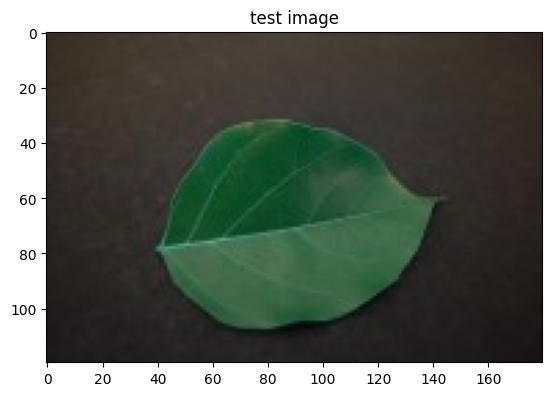

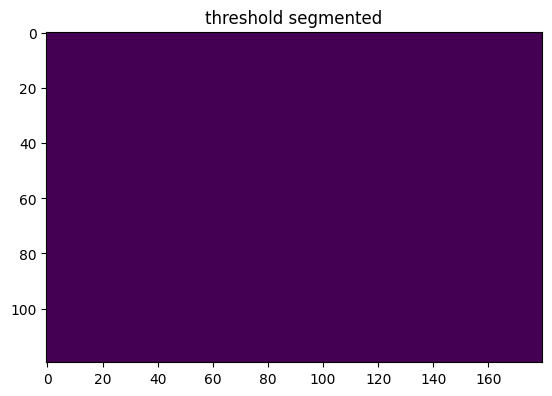

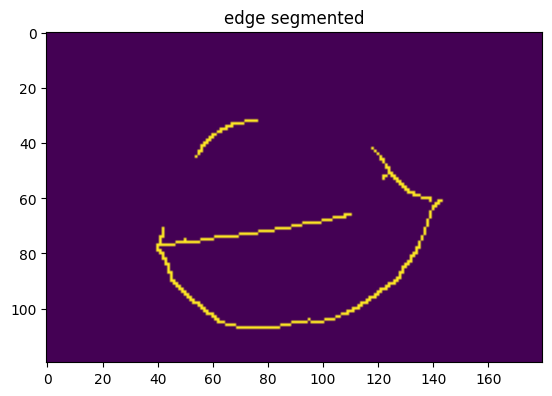

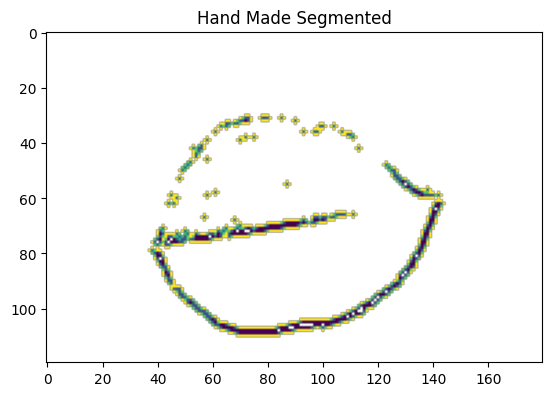

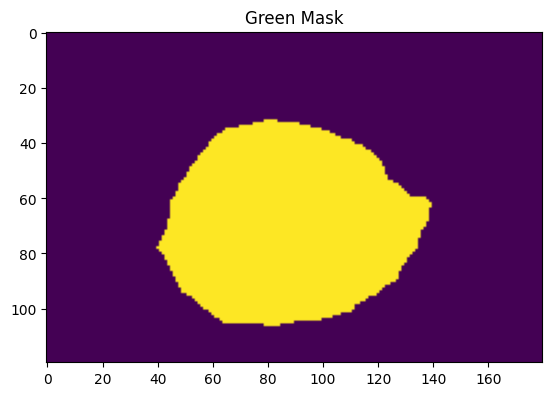

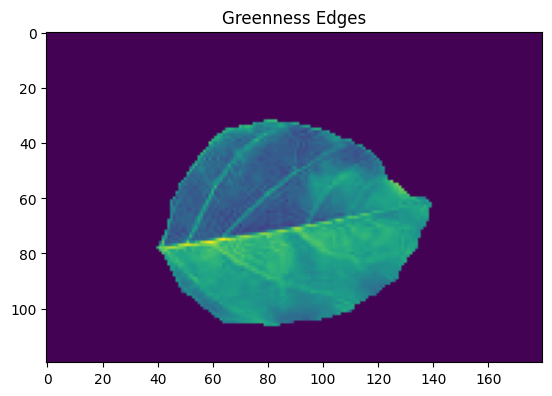

In [11]:
# Testing some of the segmentation code
# Will be removed later

test_image_path= os.path.join(PROJECT_MAP.dataDirectory, 'test.jpg')

test_image= DataProcessing.loadImage(test_image_path)
DataProcessing.displayImage(test_image, "test image")

segmented= DataProcessing.thresholdSegmentation(test_image, 150)
DataProcessing.displayImage(segmented, "threshold segmented")

edge_segmented= DataProcessing.edgeSegmentation(test_image, threshold=50)
DataProcessing.displayImage(edge_segmented, "edge segmented")

h_segmented= DataProcessing.handMadeSegmentation(test_image, 110)
DataProcessing.displayImage(h_segmented, "Hand Made Segmented")

#shows what mask output looks like
green_mask= DataProcessing.getGreennessMask(test_image)
DataProcessing.displayImage(green_mask, "Green Mask")

#shows what edges with CLAHE after greenness mask will look like
greenness_edges = DataProcessing.getEdgesFromGreenness(test_image)
DataProcessing.displayImage(greenness_edges, "Greenness Edges")


In [12]:
training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)
print(f'Classes: {classes}')
print(f'Len Classes: {len(classes)}')

for image, label in training_data.take(10):
    print("Label:", label.numpy())
#Creating dual sets
train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.getEdgesFromGreenness)
val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.getEdgesFromGreenness)
test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.getEdgesFromGreenness)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)


----------
Analyzing Training Data
----------


----------
Class distribution is the following:
{'aloevera': 799, 'banana': 799, 'bilimbi': 799, 'cantaloupe': 799, 'cassava': 799, 'coconut': 799, 'corn': 799, 'cucumber': 800, 'curcuma': 799, 'eggplant': 799, 'galangal': 799, 'ginger': 799, 'guava': 799, 'kale': 799, 'longbeans': 799, 'mango': 799, 'melon': 799, 'orange': 799, 'paddy': 799, 'papaya': 799, 'peper chili': 799, 'pineapple': 799, 'pomelo': 799, 'shallot': 799, 'soybeans': 800, 'spinach': 799, 'sweet potatoes': 799, 'tobacco': 799, 'waterapple': 799, 'watermelon': 799}
----------

Total images scanned: 500
Average image size:   (np.int64(491), np.int64(411))
Smallest image size: (np.int64(168), np.int64(140))
Largest image size:  (np.int64(2560), np.int64(2000))
Most common size:    (np.int64(225), np.int64(225)) (count: 66)

----------
Analyzing Validation Data
----------


----------
Class distribution is the following:
{'aloevera': 101, 'banana': 101, 'bilimbi': 101, 'ca

2025-07-26 21:34:41.277279: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-26 21:34:41.459847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for image, label in training_data.take(10):
    print("Label:", label.numpy())

Label: 25
Label: 0
Label: 19
Label: 2
Label: 13
Label: 22
Label: 29
Label: 4
Label: 26
Label: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..142.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-110.779..131.32].
Clipping input da

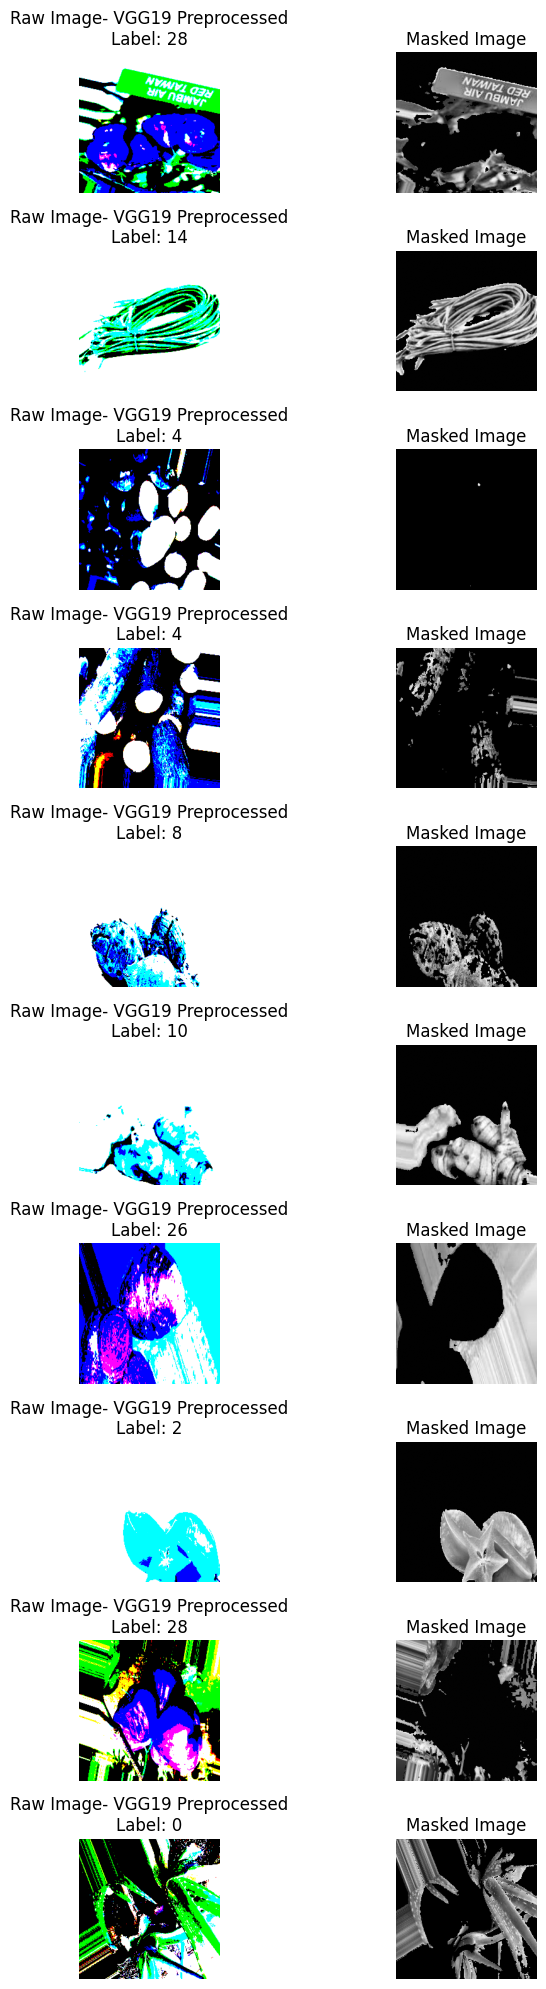

In [14]:
DataProcessing.displayProcessedImages(train_dual, 10)

In [15]:
#dual model will use both VGG19 preprocessed images and greenness threshold segmented images
#Since the outputs of each layer would potentially be different and to minimize covariate shift, we add batchnormalization: https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
#This is crucial because we are self segmenting a dataset that was not preprocessed and using a separate branch that is VGG19 preprocessed. When merging, the values can't be too different
dual_model = DualInputModel.DualInputModel(num_classes=30)
dual_model.buildModel()

training_metrics= [
    'accuracy',
    keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_3_accuracy'),
    keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
]

dual_model.compileModel(metrics=training_metrics)
training_results= dual_model.trainModel(train_dual, val_data=val_dual, epochs=10) 
test_predictions, labels, test_accuracy, test_report= dual_model.testModel(test_dual)

Model compiled
Epoch 1/10


I0000 00:00:1753580083.860170   18762 service.cc:152] XLA service 0x7fe994003ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753580083.860194   18762 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-07-26 21:34:43.977384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753580084.304610   18762 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-26 21:34:45.315600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 188 bytes spill stores, 188 bytes spill loads

2025-07-26 21:34:45.464977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

  3/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.1007 - loss: 5.3554 - top_10_accuracy: 0.4306 - top_3_accuracy: 0.1007   

I0000 00:00:1753580094.636995   18762 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4890 - loss: 1.8627 - top_10_accuracy: 0.8623 - top_3_accuracy: 0.4890

2025-07-26 21:35:29.422427: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 8 bytes spill stores, 8 bytes spill loads

2025-07-26 21:35:29.636352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 104 bytes spill stores, 104 bytes spill loads

2025-07-26 21:35:29.661980: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1634', 8 bytes spill stores, 8 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4894 - loss: 1.8608 - top_10_accuracy: 0.8625 - top_3_accuracy: 0.4894

2025-07-26 21:35:38.426514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_353', 200 bytes spill stores, 200 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - accuracy: 0.4897 - loss: 1.8599 - top_10_accuracy: 0.8626 - top_3_accuracy: 0.4897 - val_accuracy: 0.8548 - val_loss: 0.4473 - val_top_10_accuracy: 0.9970 - val_top_3_accuracy: 0.8548
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.8360 - loss: 0.5102 - top_10_accuracy: 0.9938 - top_3_accuracy: 0.8360 - val_accuracy: 0.8974 - val_loss: 0.3059 - val_top_10_accuracy: 0.9990 - val_top_3_accuracy: 0.8974
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.8858 - loss: 0.3387 - top_10_accuracy: 0.9974 - top_3_accuracy: 0.8858 - val_accuracy: 0.9165 - val_loss: 0.2374 - val_top_10_accuracy: 0.9993 - val_top_3_accuracy: 0.9165
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9178 - loss: 0.2484 - top_10_accuracy: 0.9994 - top_3_accuracy: 0.9178 - val_accuracy: 0.9135 - val_loss: 0.2648 - val_top_10_accuracy: 0.9990 - val_top_3_accuracy: 0.9135
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/st

2025-07-26 21:41:34.730354: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


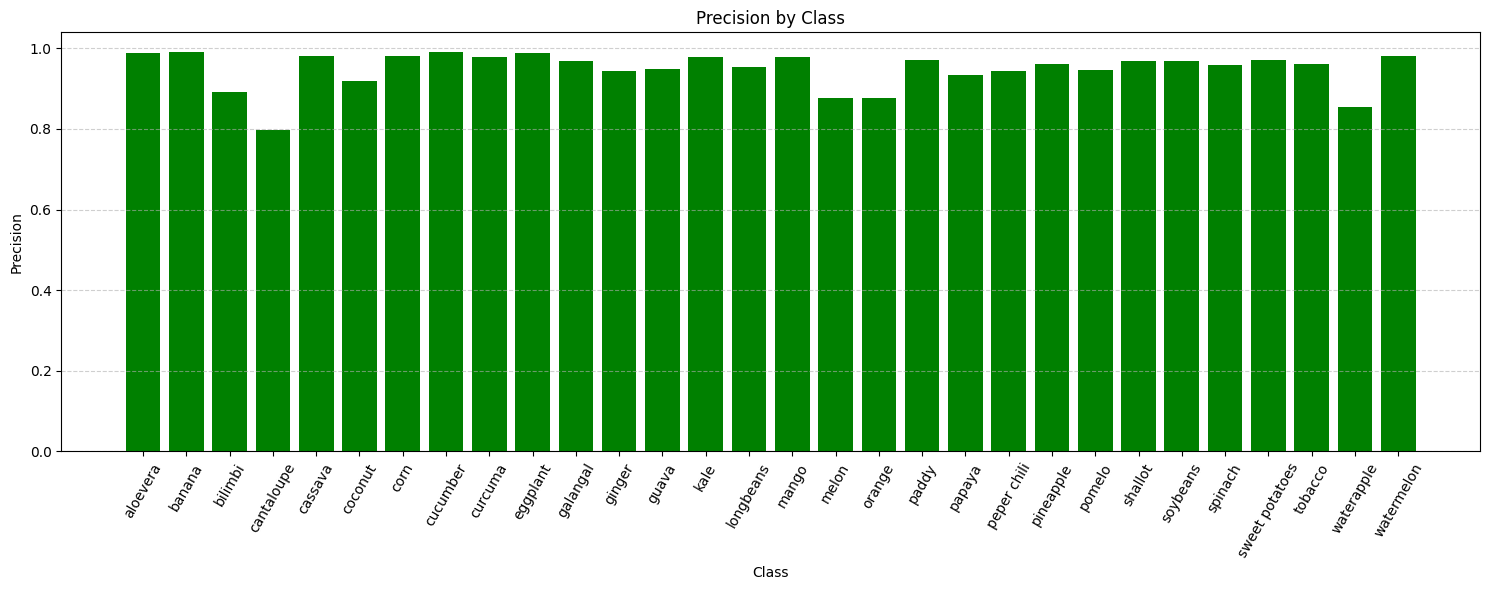

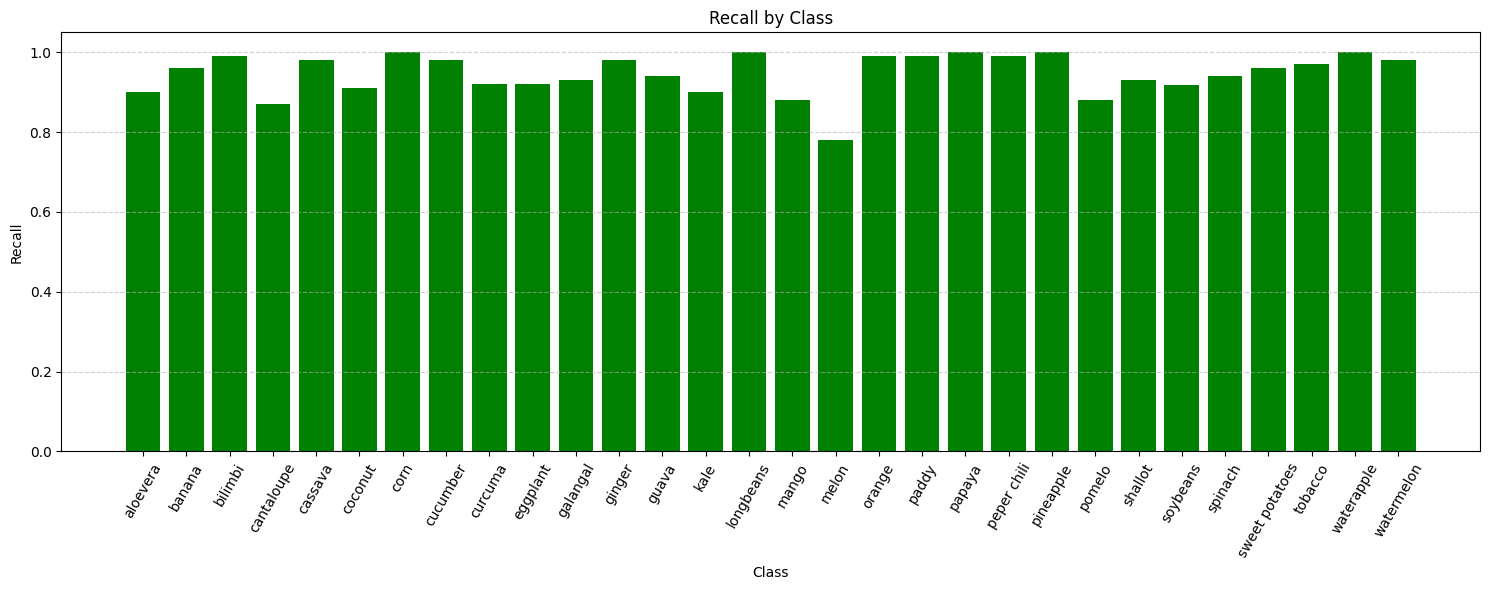

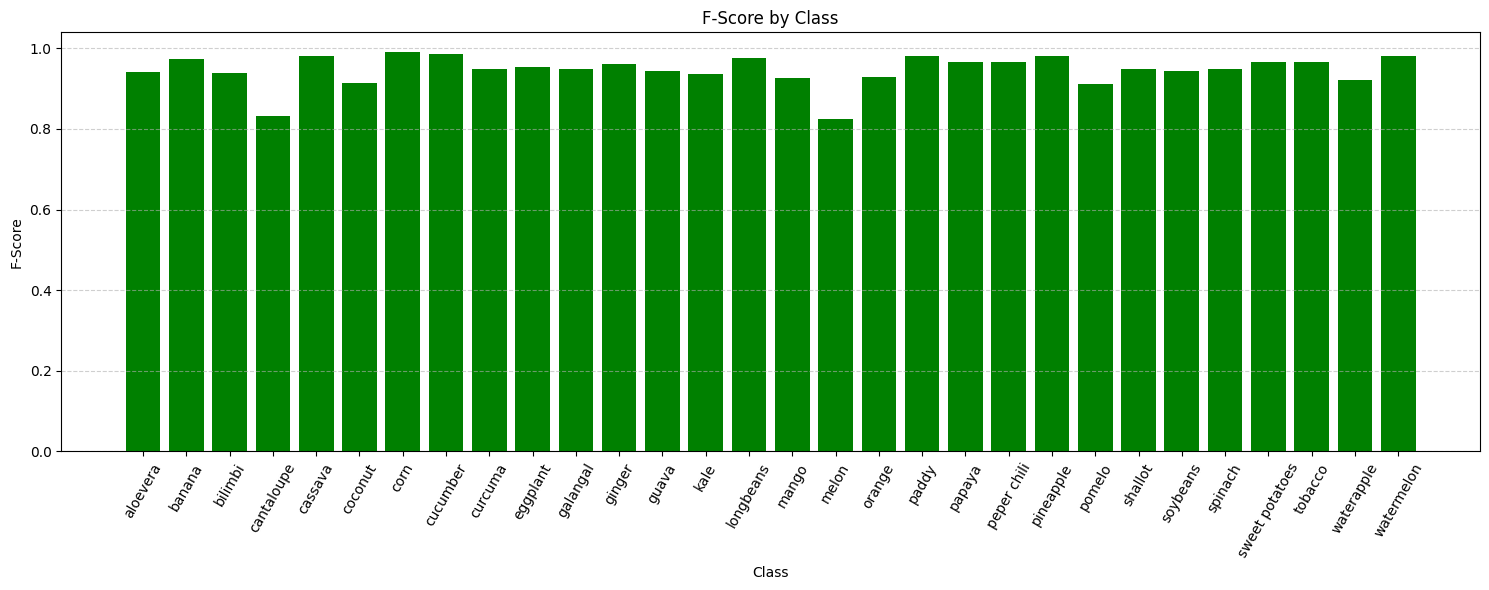

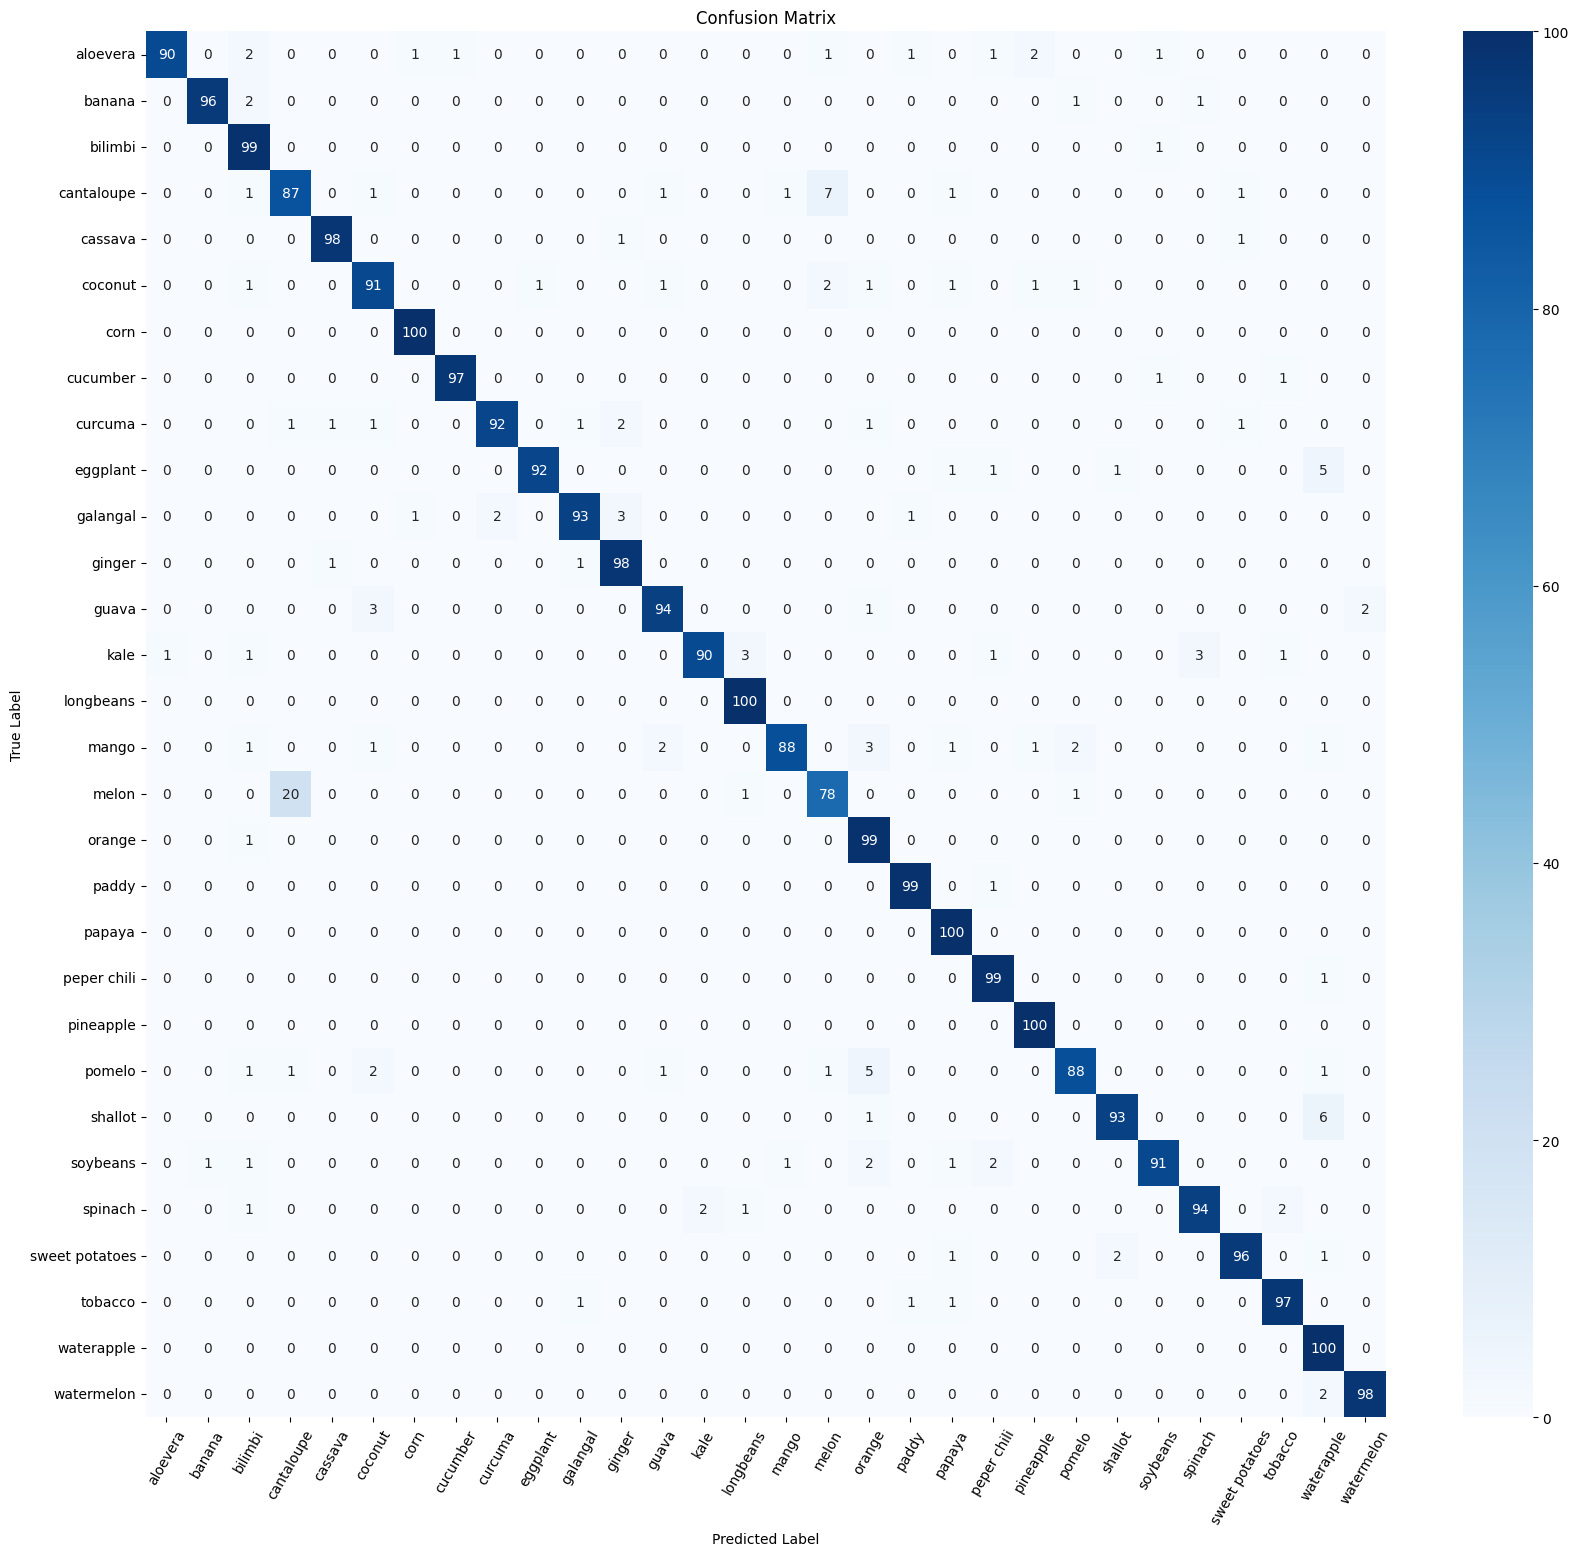

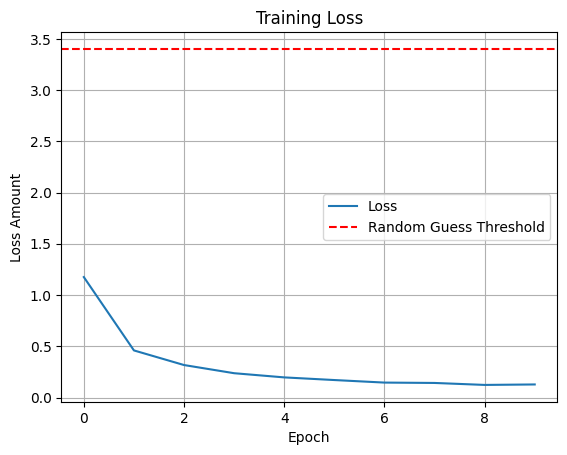

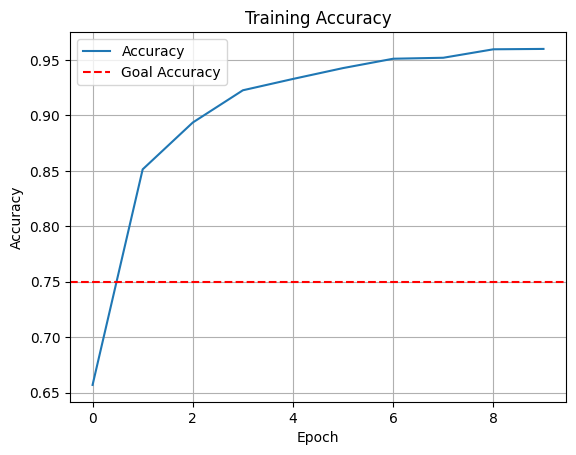

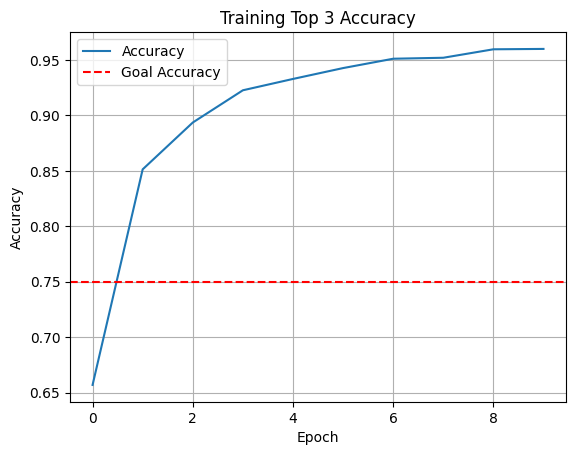

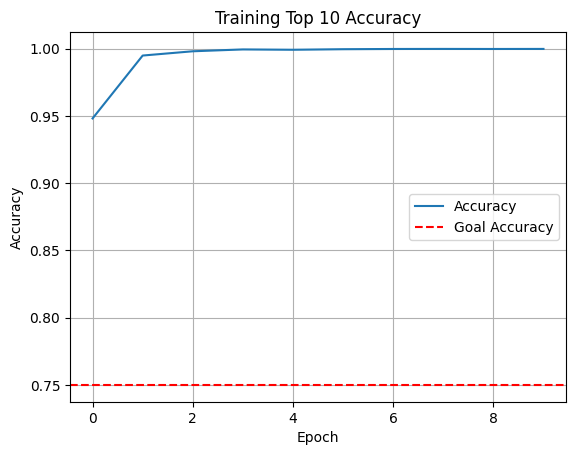

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │        320 │ mask_input[0][0]

 Total params: 20,858,396 (79.57 MB)

 Trainable params: 277,854 (1.06 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 555,710 (2.12 MB)

In [16]:
# make some graphs and whatnot for analysis
# Most of the function are defined in the Analysis.py file
import Analysis
    
class_names= training_data.class_names

training_loss= training_results.history['loss']
training_accuracy= training_results.history["accuracy"]
top_3_accuracy= training_results.history["top_3_accuracy"]
top_10_accuracy= training_results.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model.model.summary()


In [17]:
#creating a new object, since we may want to reuse the non-tuned model. This will allow us to train and compare either
dual_model_best = DualInputModel.DualInputModel(num_classes=30)
best_model_best = dual_model_best.optimize_hyperparameters(train_dual, val_dual, test_dual, model_builder=dual_model_best.buildHPModel)

#Grab untrained hyperparameters
best_hps = dual_model_best.tuner.get_best_hyperparameters(1)[0]
untrained_model = dual_model_best.buildHPModel(best_hps)
dual_model_best.model = untrained_model
training_results_best = dual_model_best.trainModel(train_dual, val_data=val_dual, epochs=10)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(test_dual)

Trial 10 Complete [00h 06m 50s]
val_accuracy: 0.9471946954727173

Best val_accuracy So Far: 0.9597359895706177
Total elapsed time: 01h 07m 47s
Results summary
Results in plant_tuner/plant_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
dense1_units: 192
dense2_units: 128
dense3_units: 512
dropout1: 0.30000000000000004
dense4_units: 192
dropout2: 0.30000000000000004
learning_rate: 0.001
Score: 0.9597359895706177

Trial 03 summary
Hyperparameters:
dense1_units: 192
dense2_units: 256
dense3_units: 384
dropout1: 0.2
dense4_units: 256
dropout2: 0.1
learning_rate: 0.001
Score: 0.9584158658981323

Trial 00 summary
Hyperparameters:
dense1_units: 192
dense2_units: 128
dense3_units: 512
dropout1: 0.2
dense4_units: 192
dropout2: 0.30000000000000004
learning_rate: 0.001
Score: 0.9524752497673035

Trial 09 summary
Hyperparameters:
dense1_units: 256
dense2_units: 64
dense3_units: 256
dropout1: 0.4
dense4_units: 256
dropout2: 0.4
learnin

/home/codyrgould/tf-gpu/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.5285 - loss: 1.7381 - top_10_accuracy: 0.8833 - top_3_accuracy: 0.7257 - val_accuracy: 0.8607 - val_loss: 0.4246 - val_top_10_accuracy: 0.9967 - val_top_3_accuracy: 0.9706
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8484 - loss: 0.4664 - top_10_accuracy: 0.9957 - top_3_accuracy: 0.9657 - val_accuracy: 0.9003 - val_loss: 0.3029 - val_top_10_accuracy: 0.9990 - val_top_3_accuracy: 0.9835
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8999 - loss: 0.3026 - top_10_accuracy: 0.9983 - top_3_accuracy: 0.9856 - val_accuracy: 0.9178 - val_loss: 0.2526 - val_top_10_accuracy: 0.9993 - val_top_3_accuracy: 0.9891
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9261 - loss: 0.2257 - top_10_accuracy: 0.9996 - top_3_accuracy: 0.9907 - val_accuracy: 0.9304 - val_loss: 0.2180 - val_top_10_accuracy: 0.9997 - val_top_3_accuracy: 0.9921
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/st

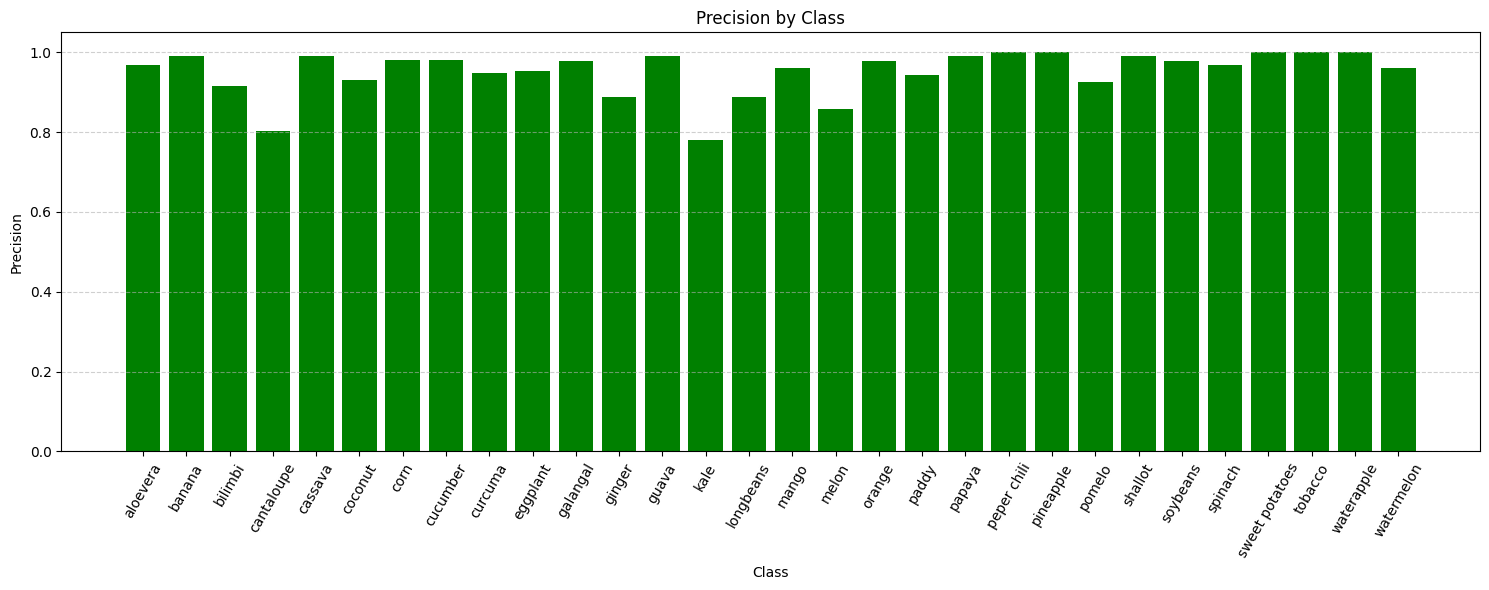

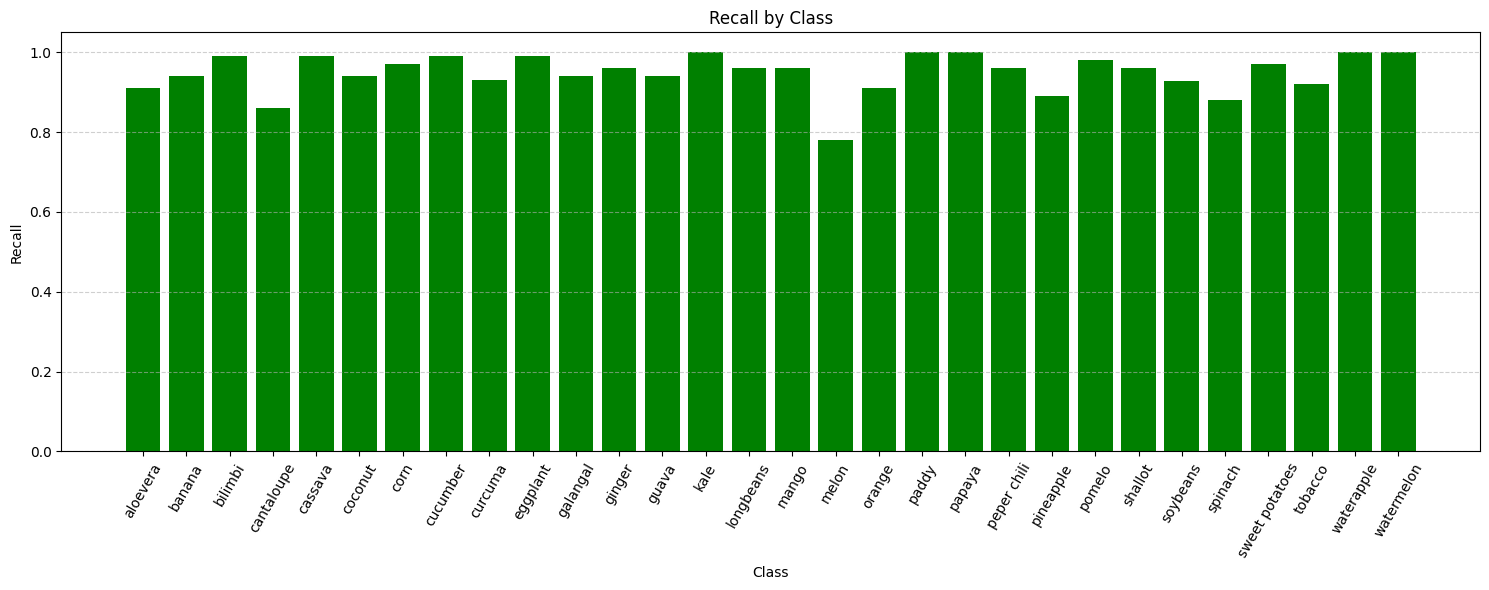

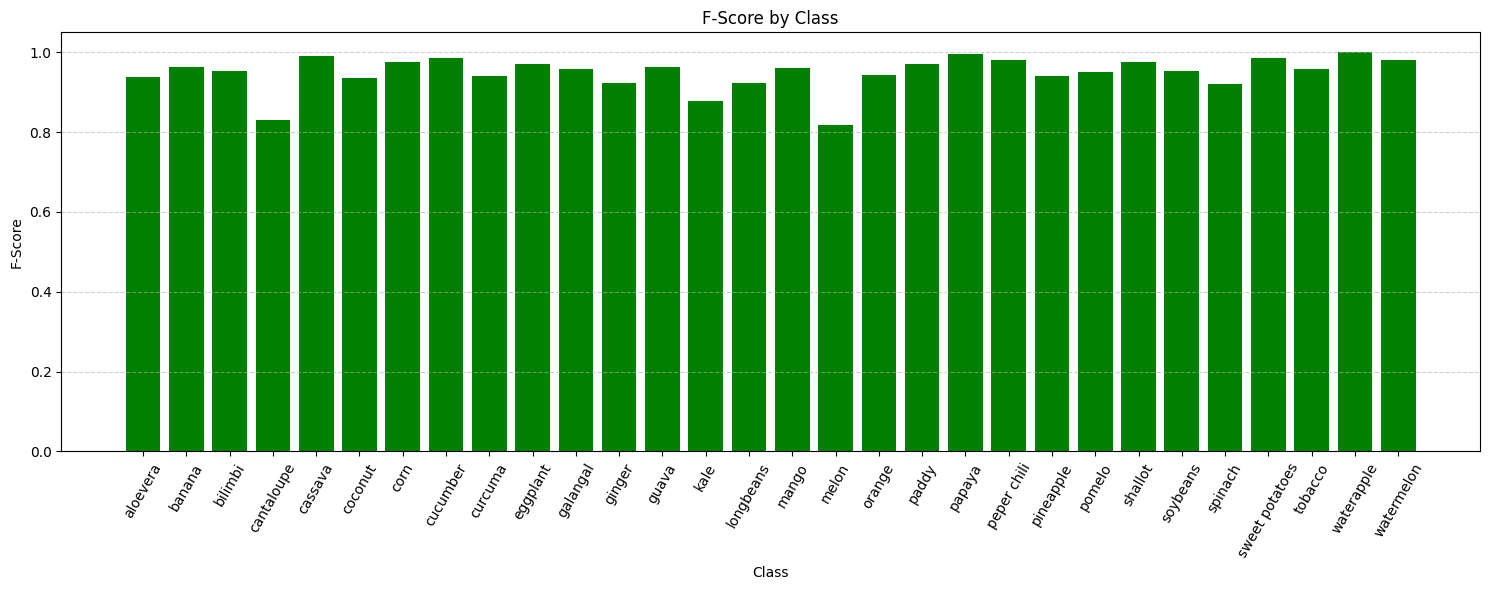

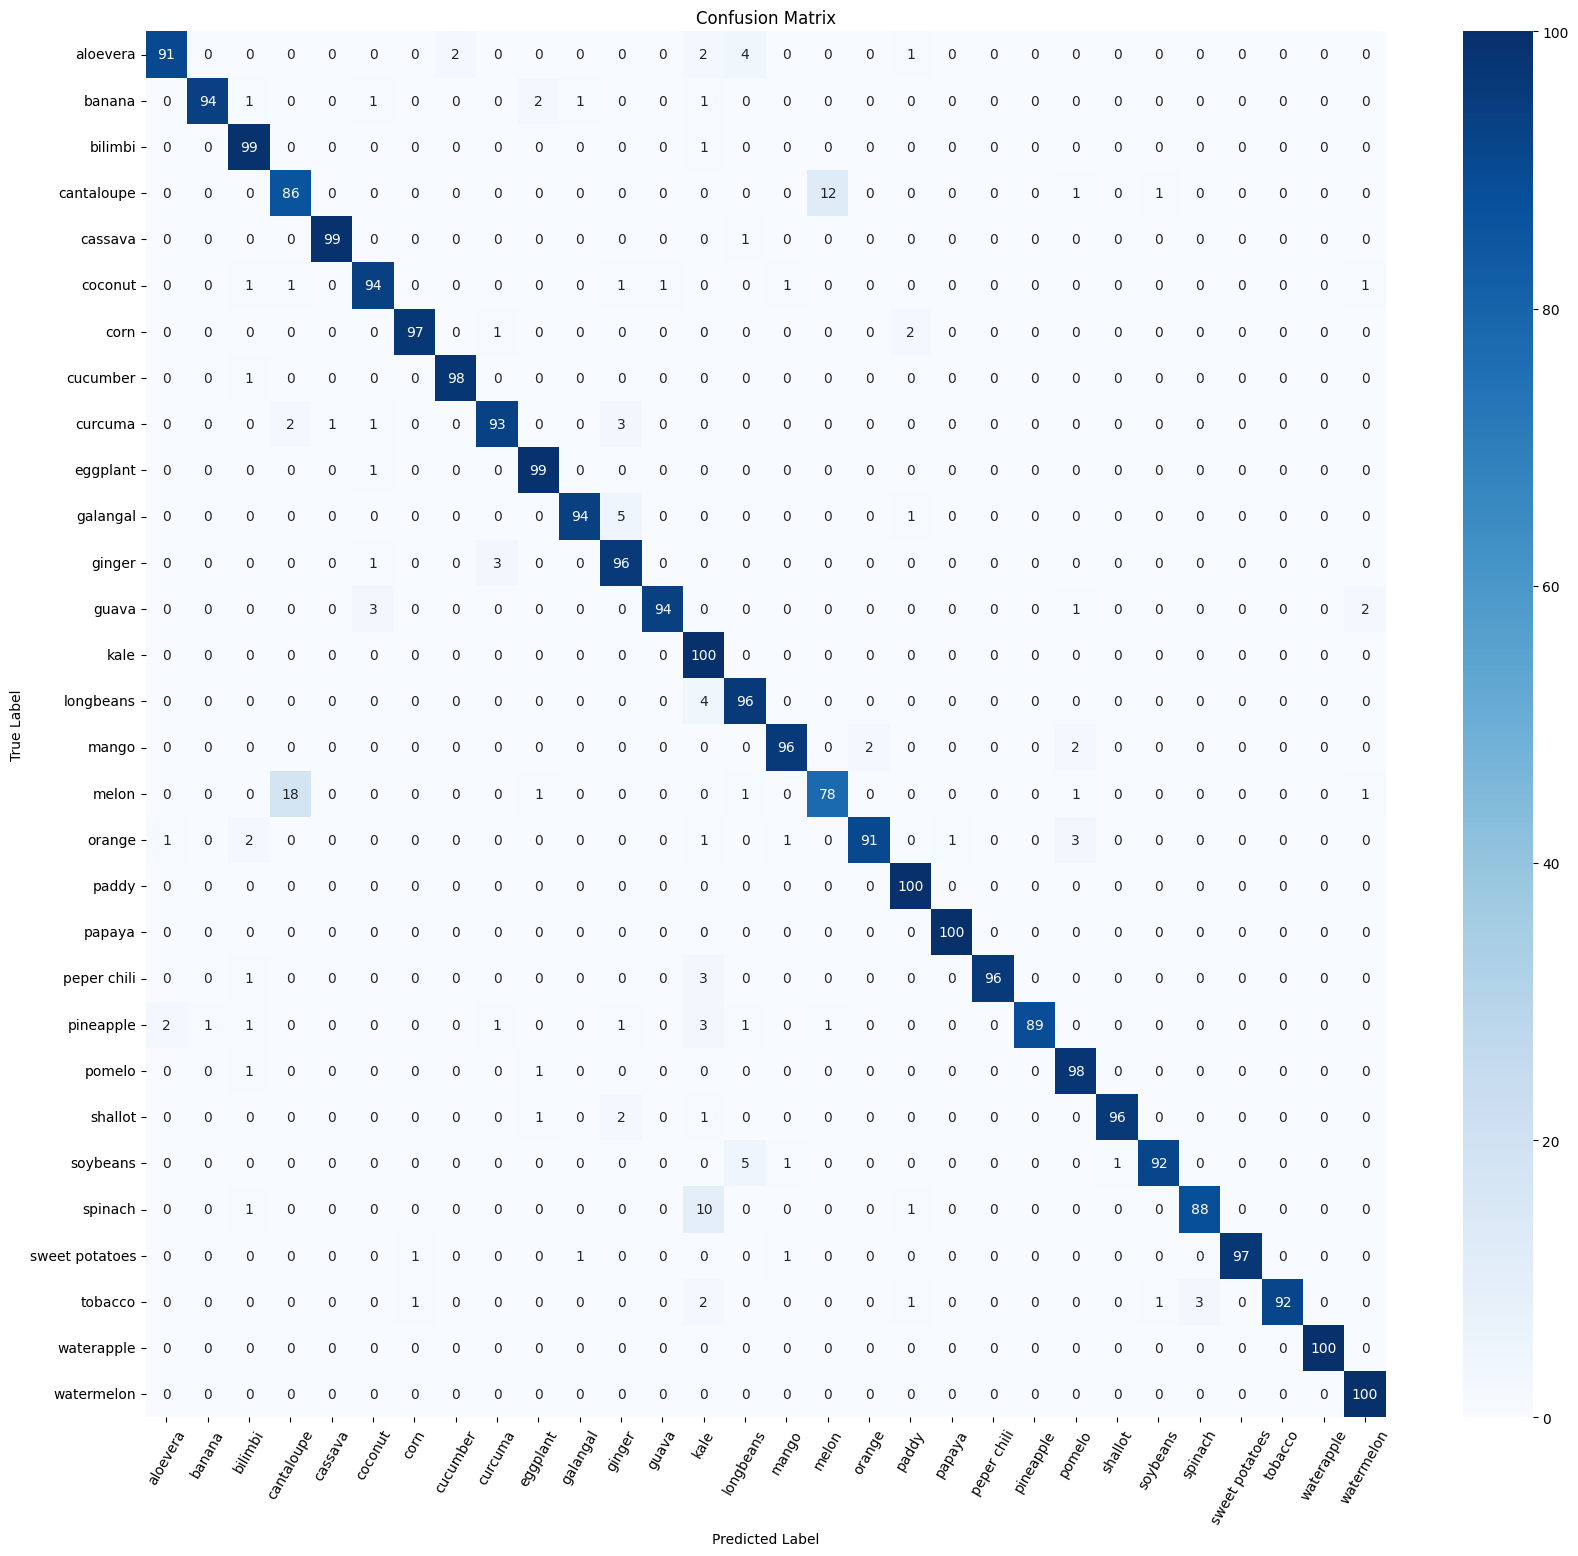

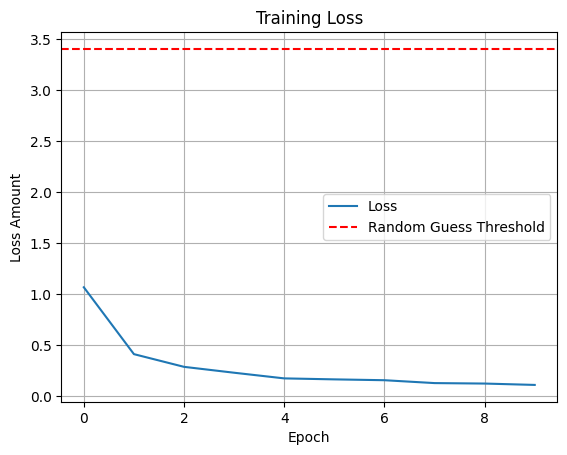

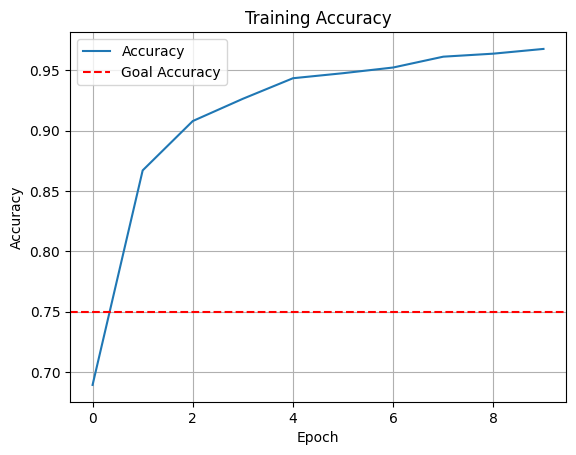

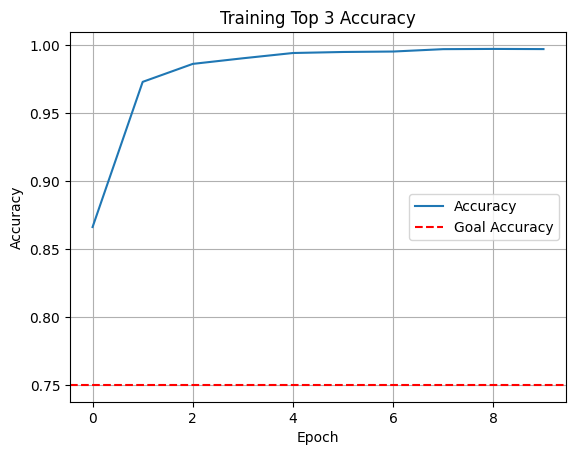

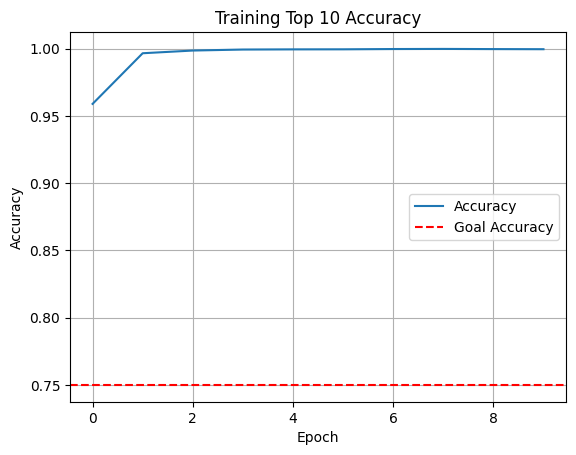

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        320 │ mask_input[0][0]

 Total params: 21,455,132 (81.84 MB)

 Trainable params: 476,766 (1.82 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 953,534 (3.64 MB)

In [18]:
class_names= training_data.class_names

training_loss= training_results_best.history['loss']
training_accuracy= training_results_best.history["accuracy"]
top_3_accuracy= training_results_best.history["top_3_accuracy"]
top_10_accuracy= training_results_best.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [19]:
dual_model_best.model.save("best_plant_model.keras")

In [20]:
#Attempt with adaptive segmentation
importlib.reload(DataProcessing)
adaptive_train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.adaptive_segmentation)
adaptive_val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.adaptive_segmentation)
adaptive_test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.adaptive_segmentation)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)

Raw shape: (32, 224, 224, 3)
Mask shape: (32, 224, 224, 1)
Label shape: (32,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..125.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..146.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..122.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.779..141.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data t

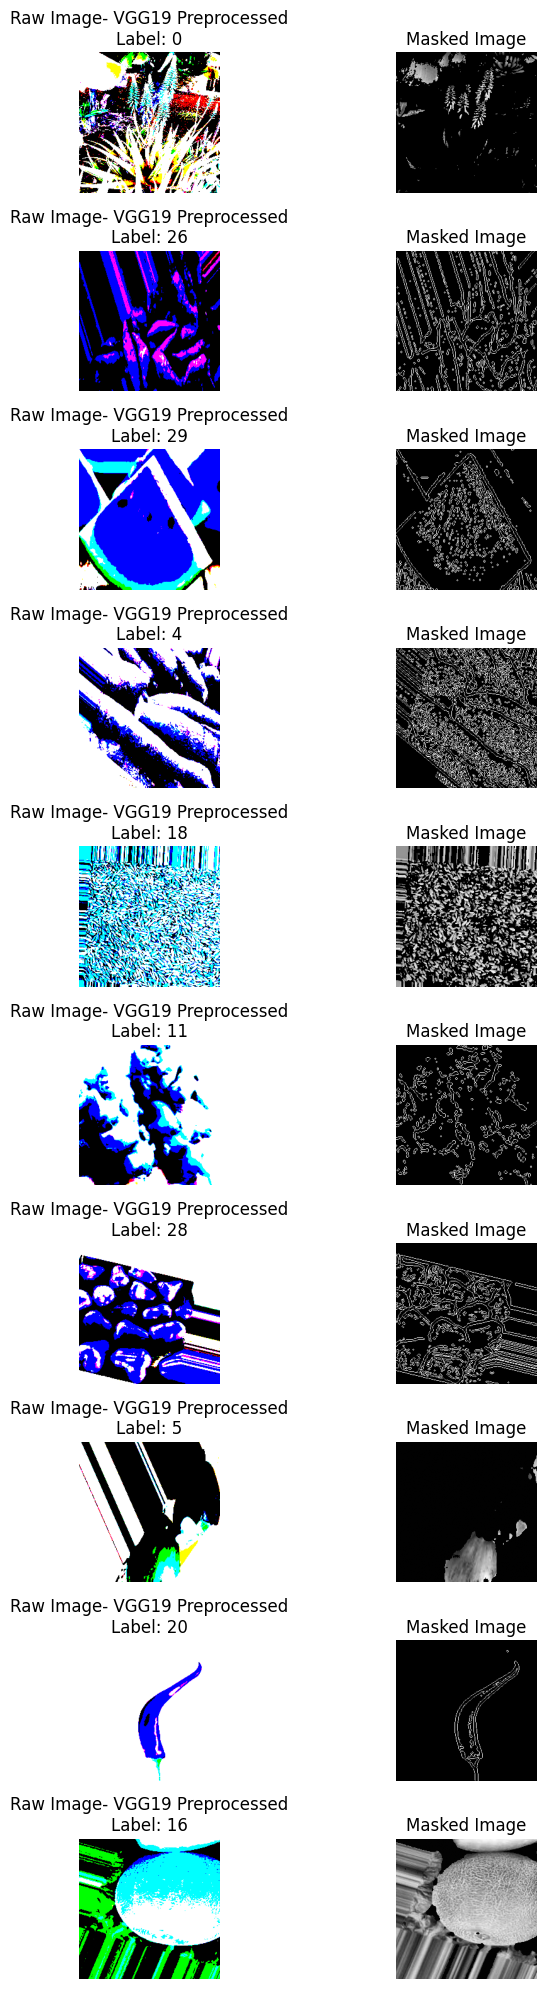

In [21]:
DataProcessing.displayProcessedImages(adaptive_train_dual, 10)

In [22]:
#Grab untrained hyperparameters
best_hps = dual_model_best.tuner.get_best_hyperparameters(1)[0]
untrained_model = dual_model_best.buildHPModel(best_hps)
dual_model_best.model = untrained_model

adaptive_segmentation_results = dual_model_best.trainModel(adaptive_train_dual, epochs=10, val_data=adaptive_val_dual)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(adaptive_test_dual)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.5257 - loss: 1.7352 - top_10_accuracy: 0.8787 - top_3_accuracy: 0.7207 - val_accuracy: 0.8693 - val_loss: 0.3977 - val_top_10_accuracy: 0.9970 - val_top_3_accuracy: 0.9700
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8484 - loss: 0.4807 - top_10_accuracy: 0.9958 - top_3_accuracy: 0.9664 - val_accuracy: 0.8832 - val_loss: 0.3456 - val_top_10_accuracy: 0.9980 - val_top_3_accuracy: 0.9815
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9022 - loss: 0.3050 - top_10_accuracy: 0.9979 - top_3_accuracy: 0.9839 - val_accuracy: 0.9261 - val_loss: 0.2216 - val_top_10_accuracy: 0.9983 - val_top_3_accuracy: 0.9898
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.9281 - loss: 0.2165 - top_10_accuracy: 0.9991 - top_3_accuracy: 0.9911 - val_accuracy: 0.9254 - val_loss: 0.2226 - val_top_10_accuracy: 0.9997 - val_top_3_accuracy: 0.9908
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

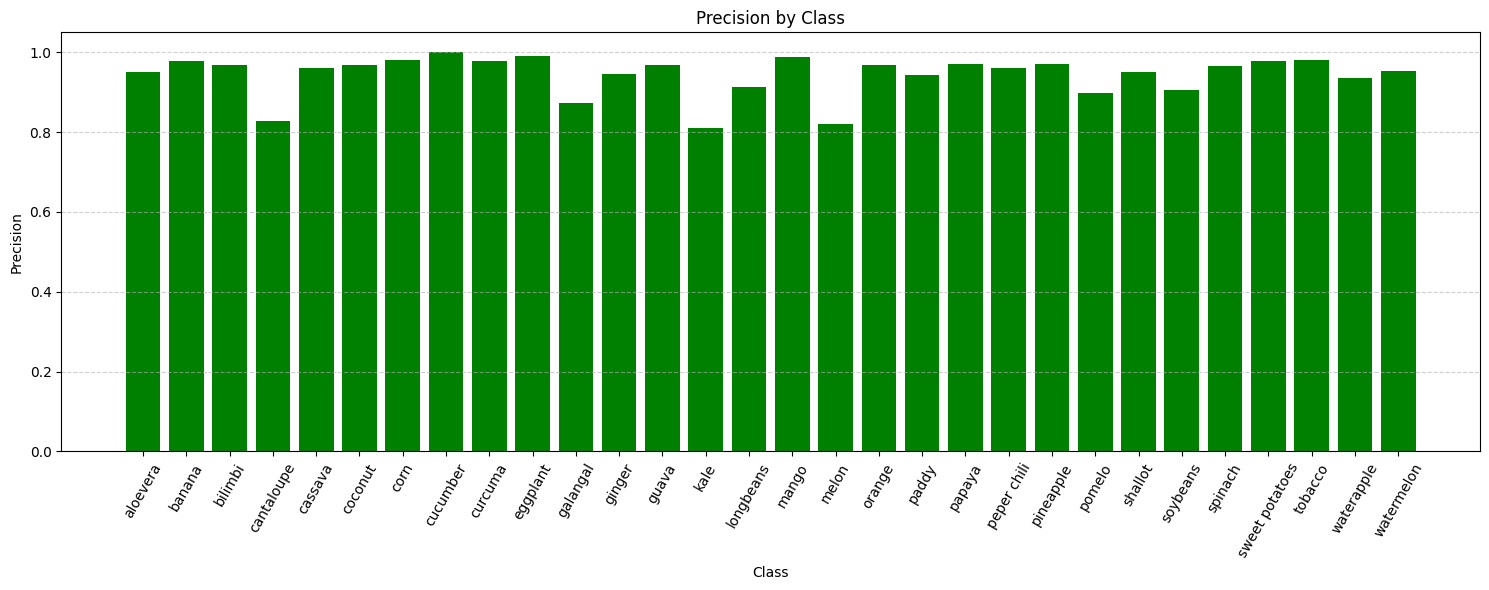

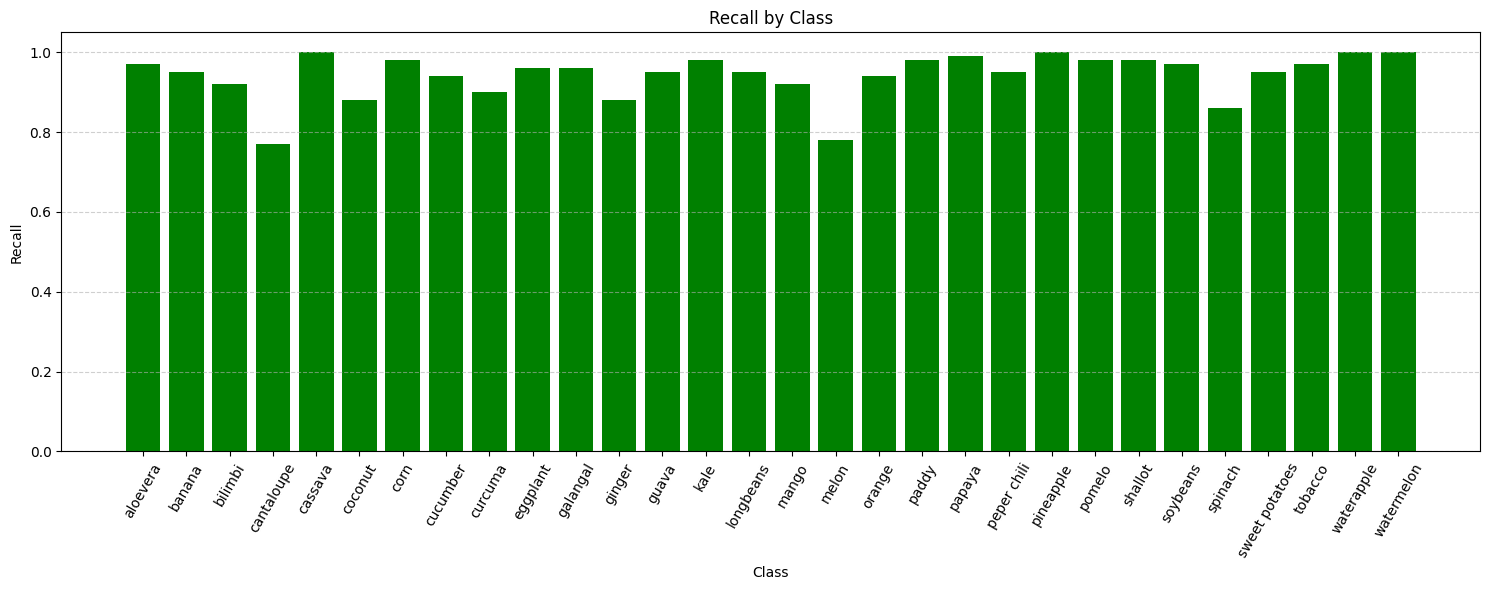

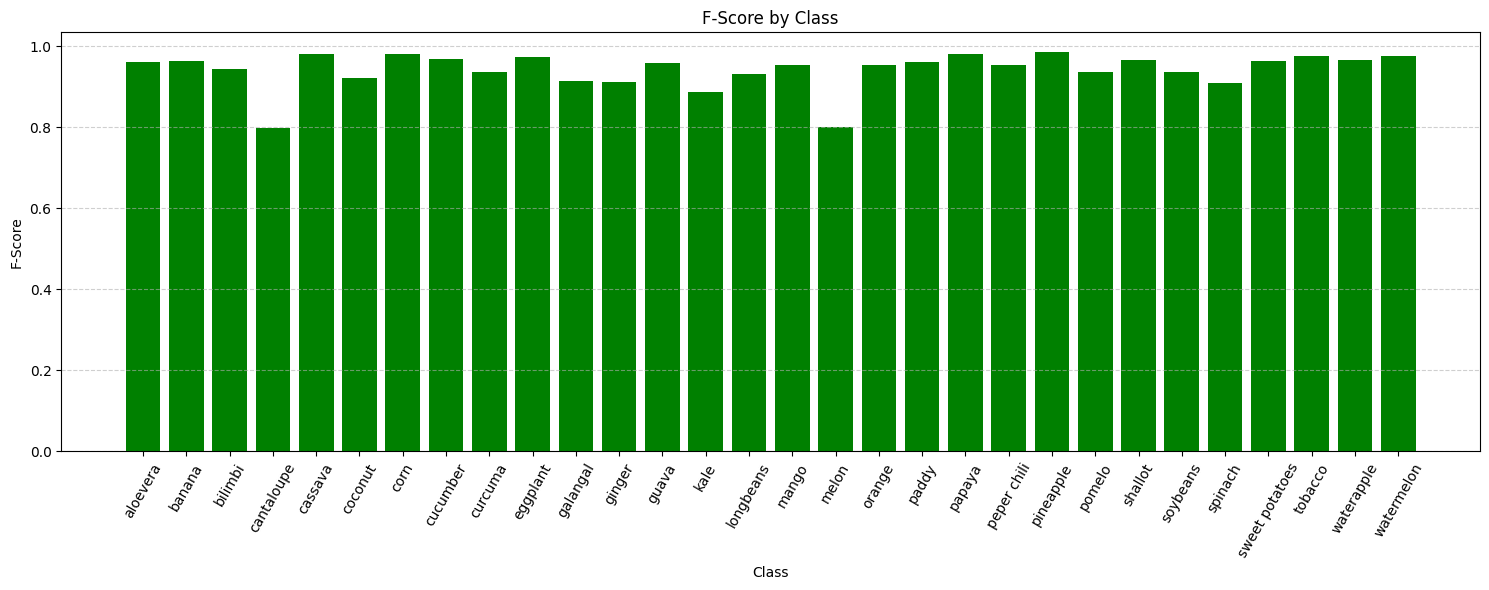

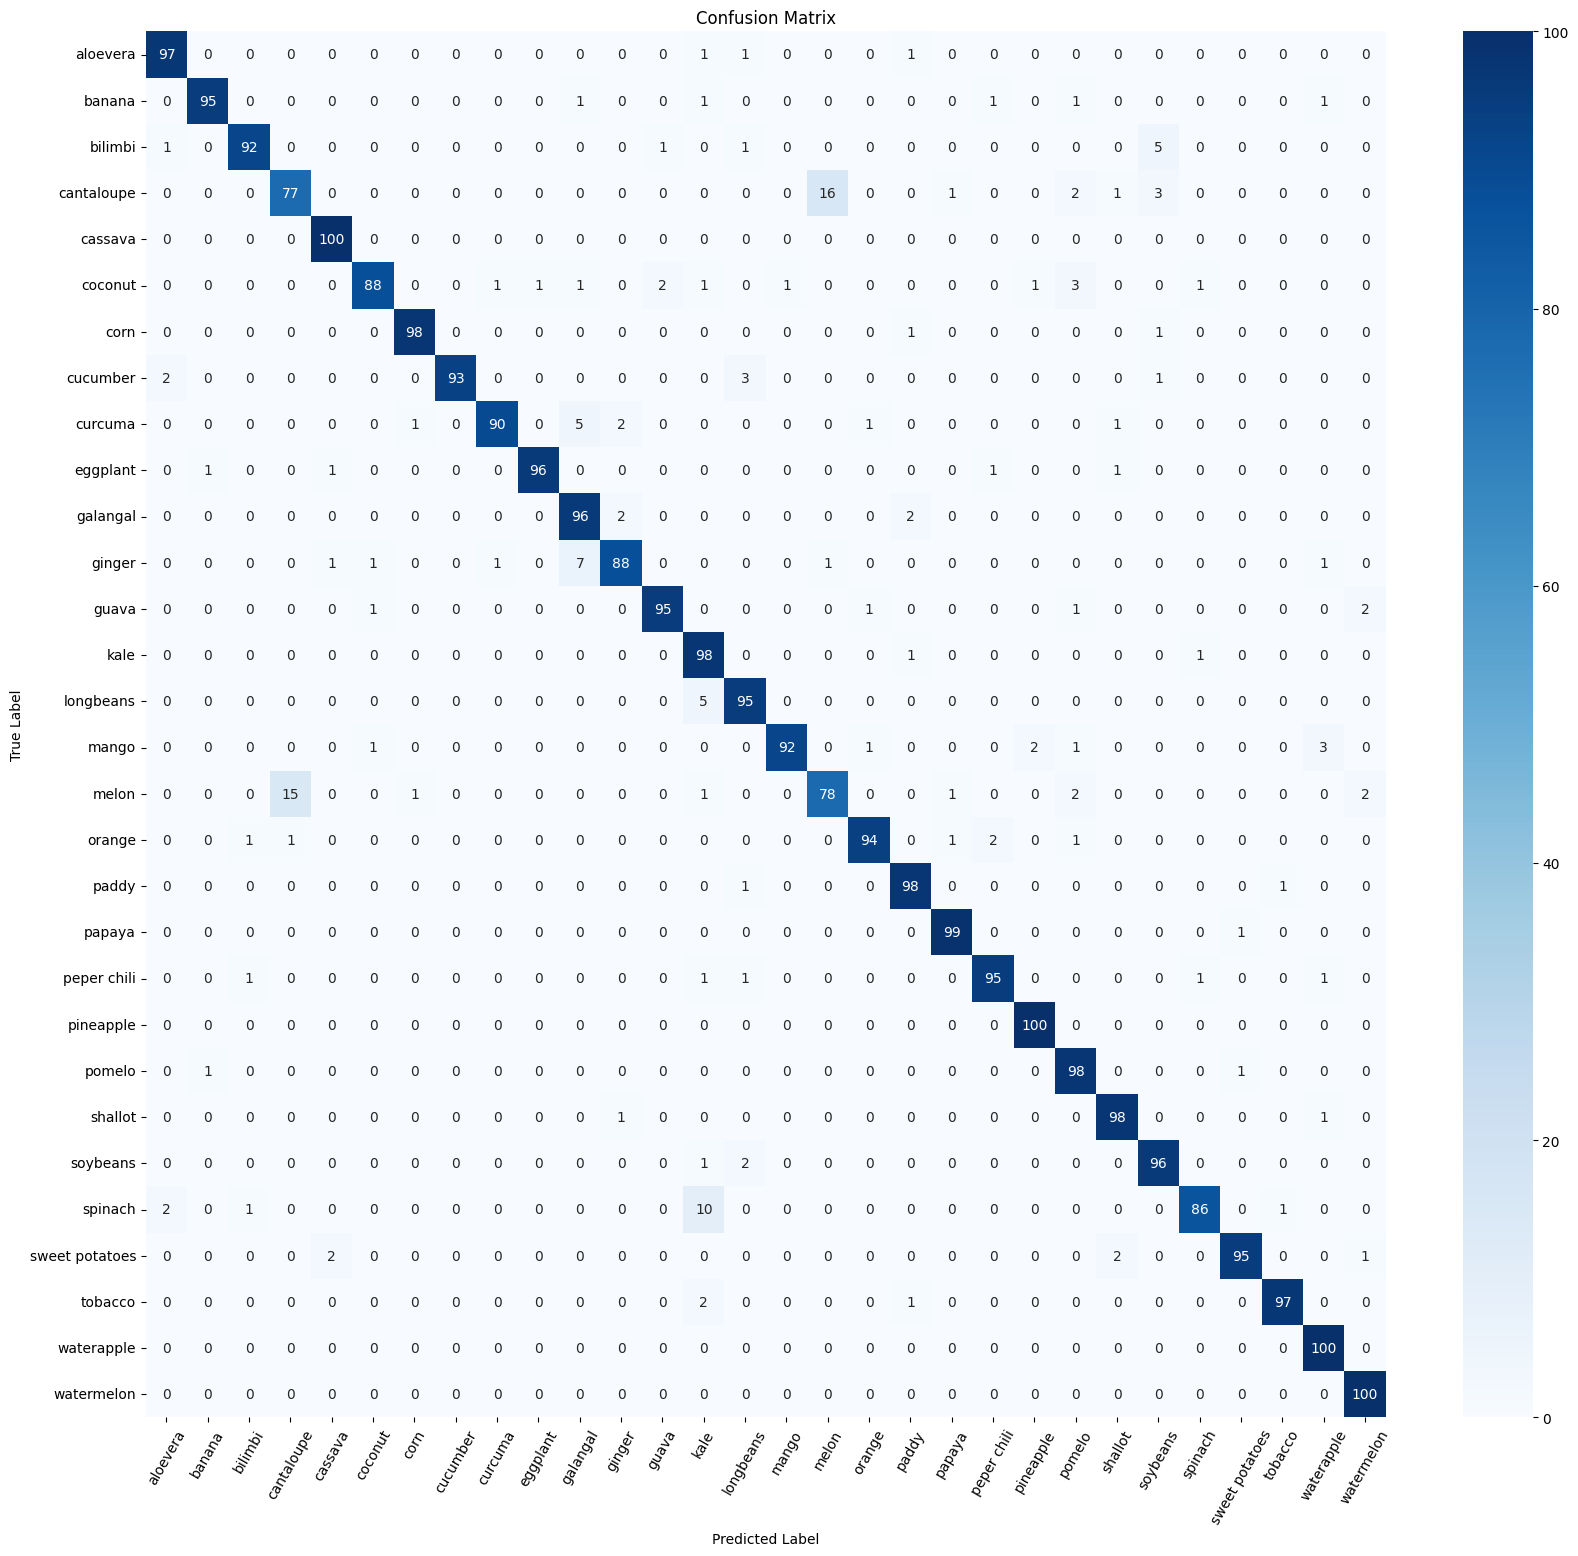

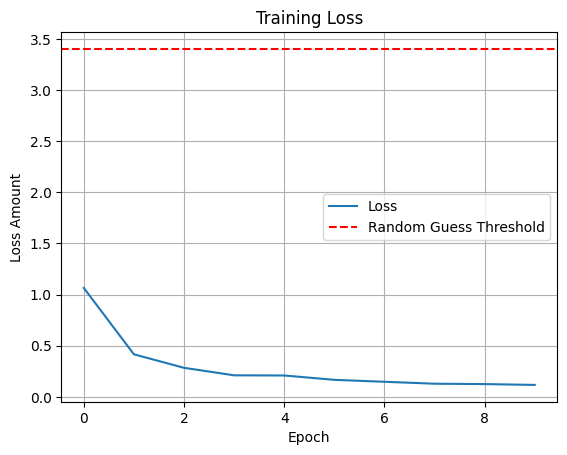

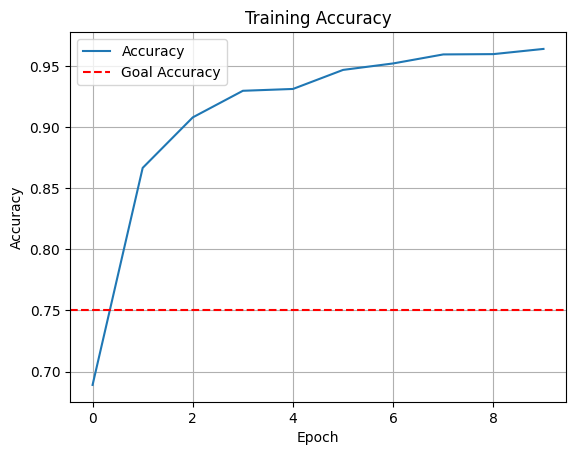

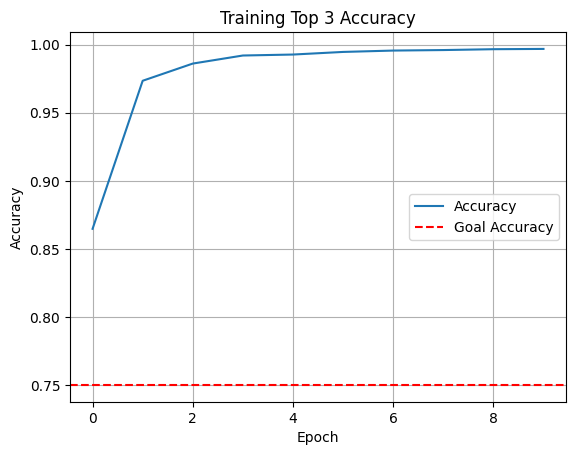

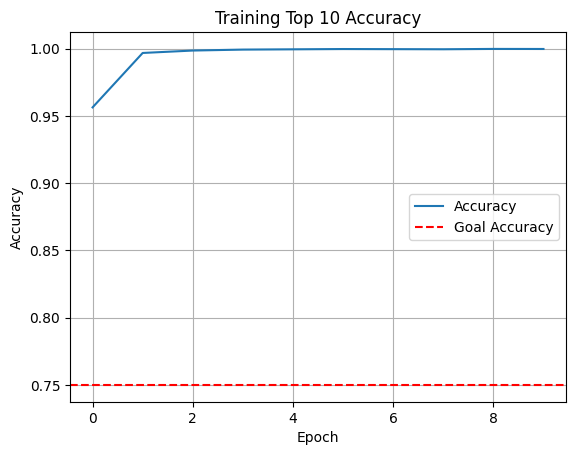

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        320 │ mask_input[0][0]

 Total params: 21,455,132 (81.84 MB)

 Trainable params: 476,766 (1.82 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 953,534 (3.64 MB)

In [23]:
class_names = training_data.class_names

training_loss = adaptive_segmentation_results.history['loss']
training_accuracy = adaptive_segmentation_results.history["accuracy"]
top_3_accuracy = adaptive_segmentation_results.history["top_3_accuracy"]
top_10_accuracy = adaptive_segmentation_results.history['top_10_accuracy']

precision, recall, fscore, support = Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [24]:
#saving at 10 epochs
dual_model_best.model.save("adative_best_plant_model.keras")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9691 - loss: 0.1060 - top_10_accuracy: 0.9999 - top_3_accuracy: 0.9968 - val_accuracy: 0.9432 - val_loss: 0.1997 - val_top_10_accuracy: 0.9987 - val_top_3_accuracy: 0.9911
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9657 - loss: 0.1076 - top_10_accuracy: 0.9997 - top_3_accuracy: 0.9969 - val_accuracy: 0.9591 - val_loss: 0.1556 - val_top_10_accuracy: 0.9993 - val_top_3_accuracy: 0.9967
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9738 - loss: 0.0816 - top_10_accuracy: 0.9999 - top_3_accuracy: 0.9985 - val_accuracy: 0.9551 - val_loss: 0.1849 - val_top_10_accuracy: 0.9993 - val_top_3_accuracy: 0.9944
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9708 - loss: 0.1045 - top_10_accuracy: 0.9999 - top_3_accuracy: 0.9973 - val_accuracy: 0.9574 - val_loss: 0.1682 - val_top_10_accuracy: 0.9993 - val_top_3_accuracy: 0.9954
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 5

2025-07-26 23:06:24.488778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


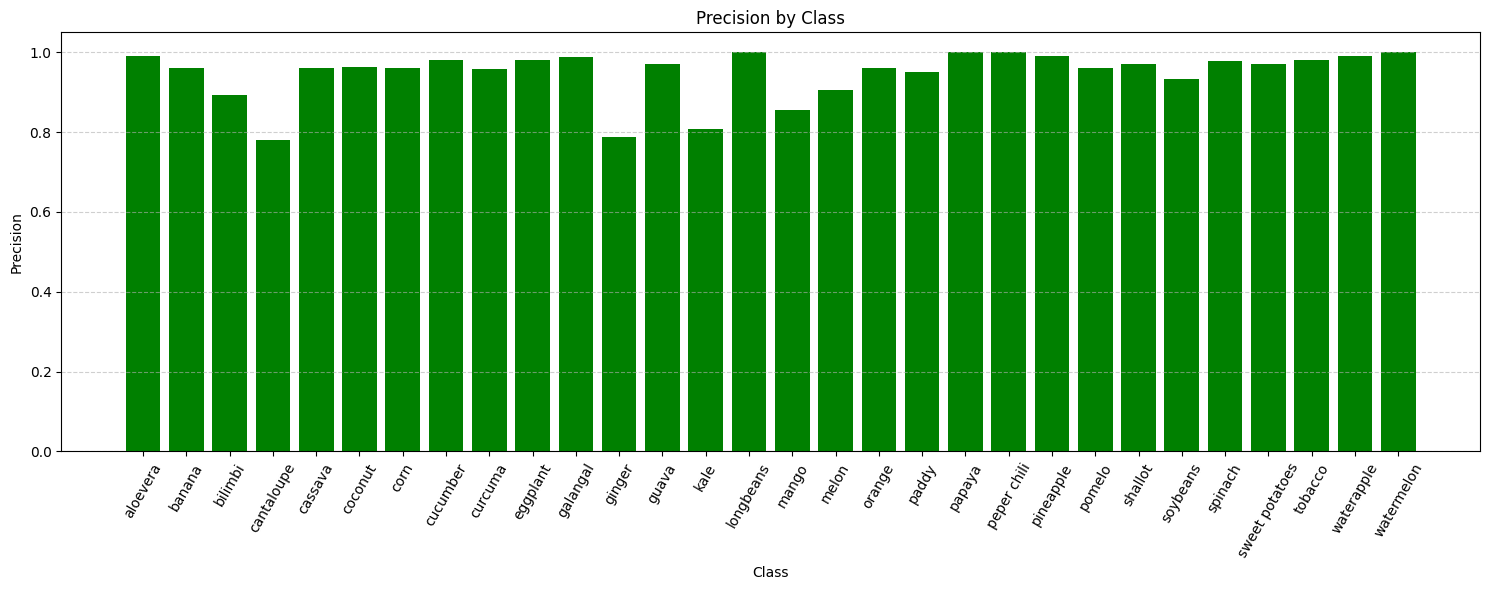

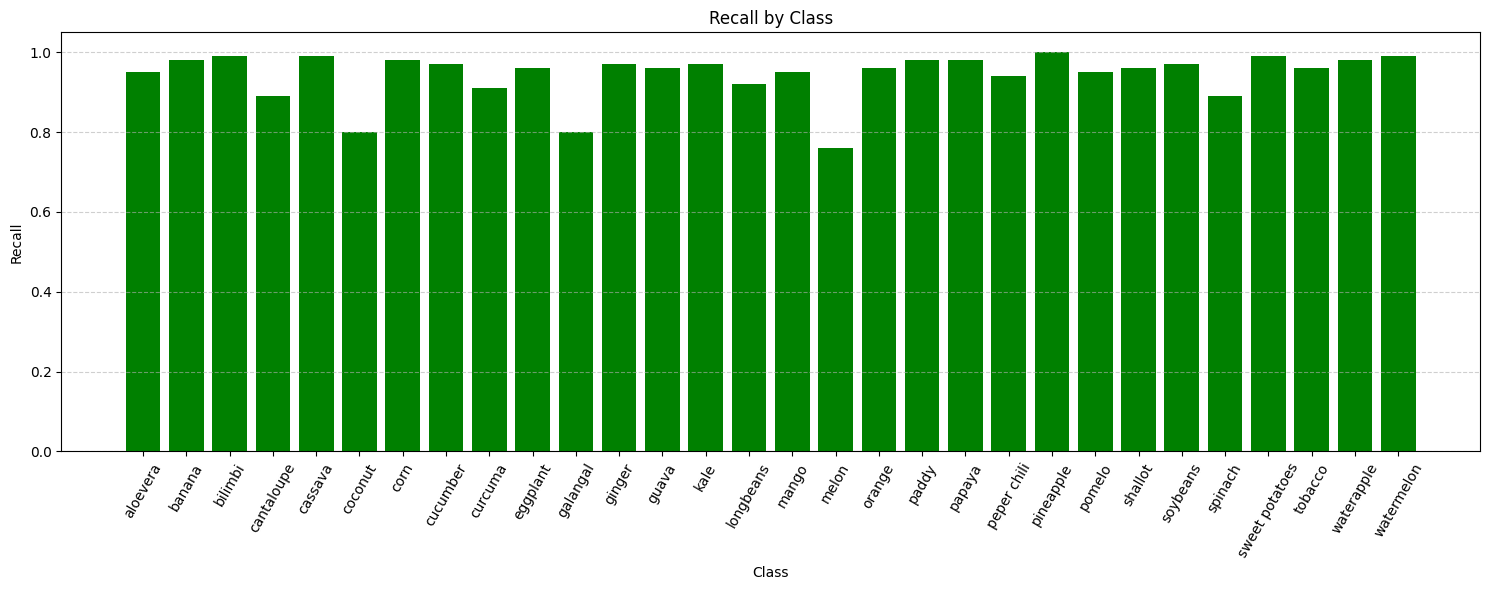

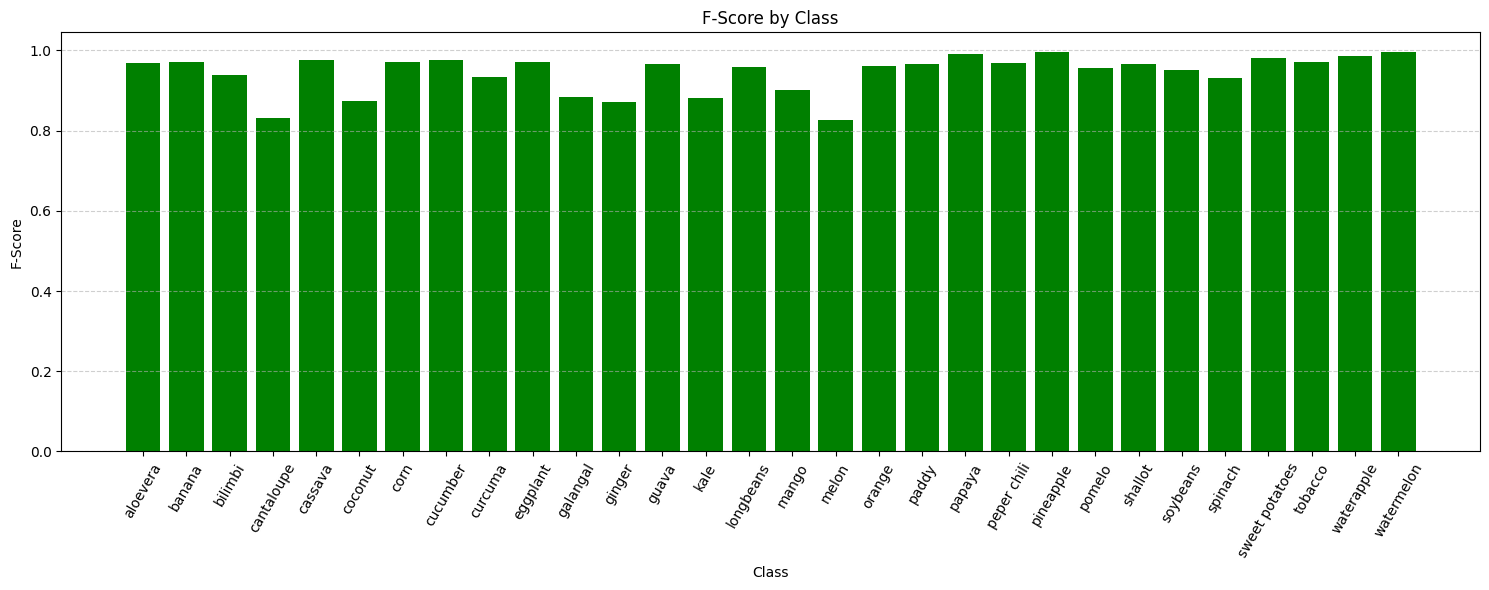

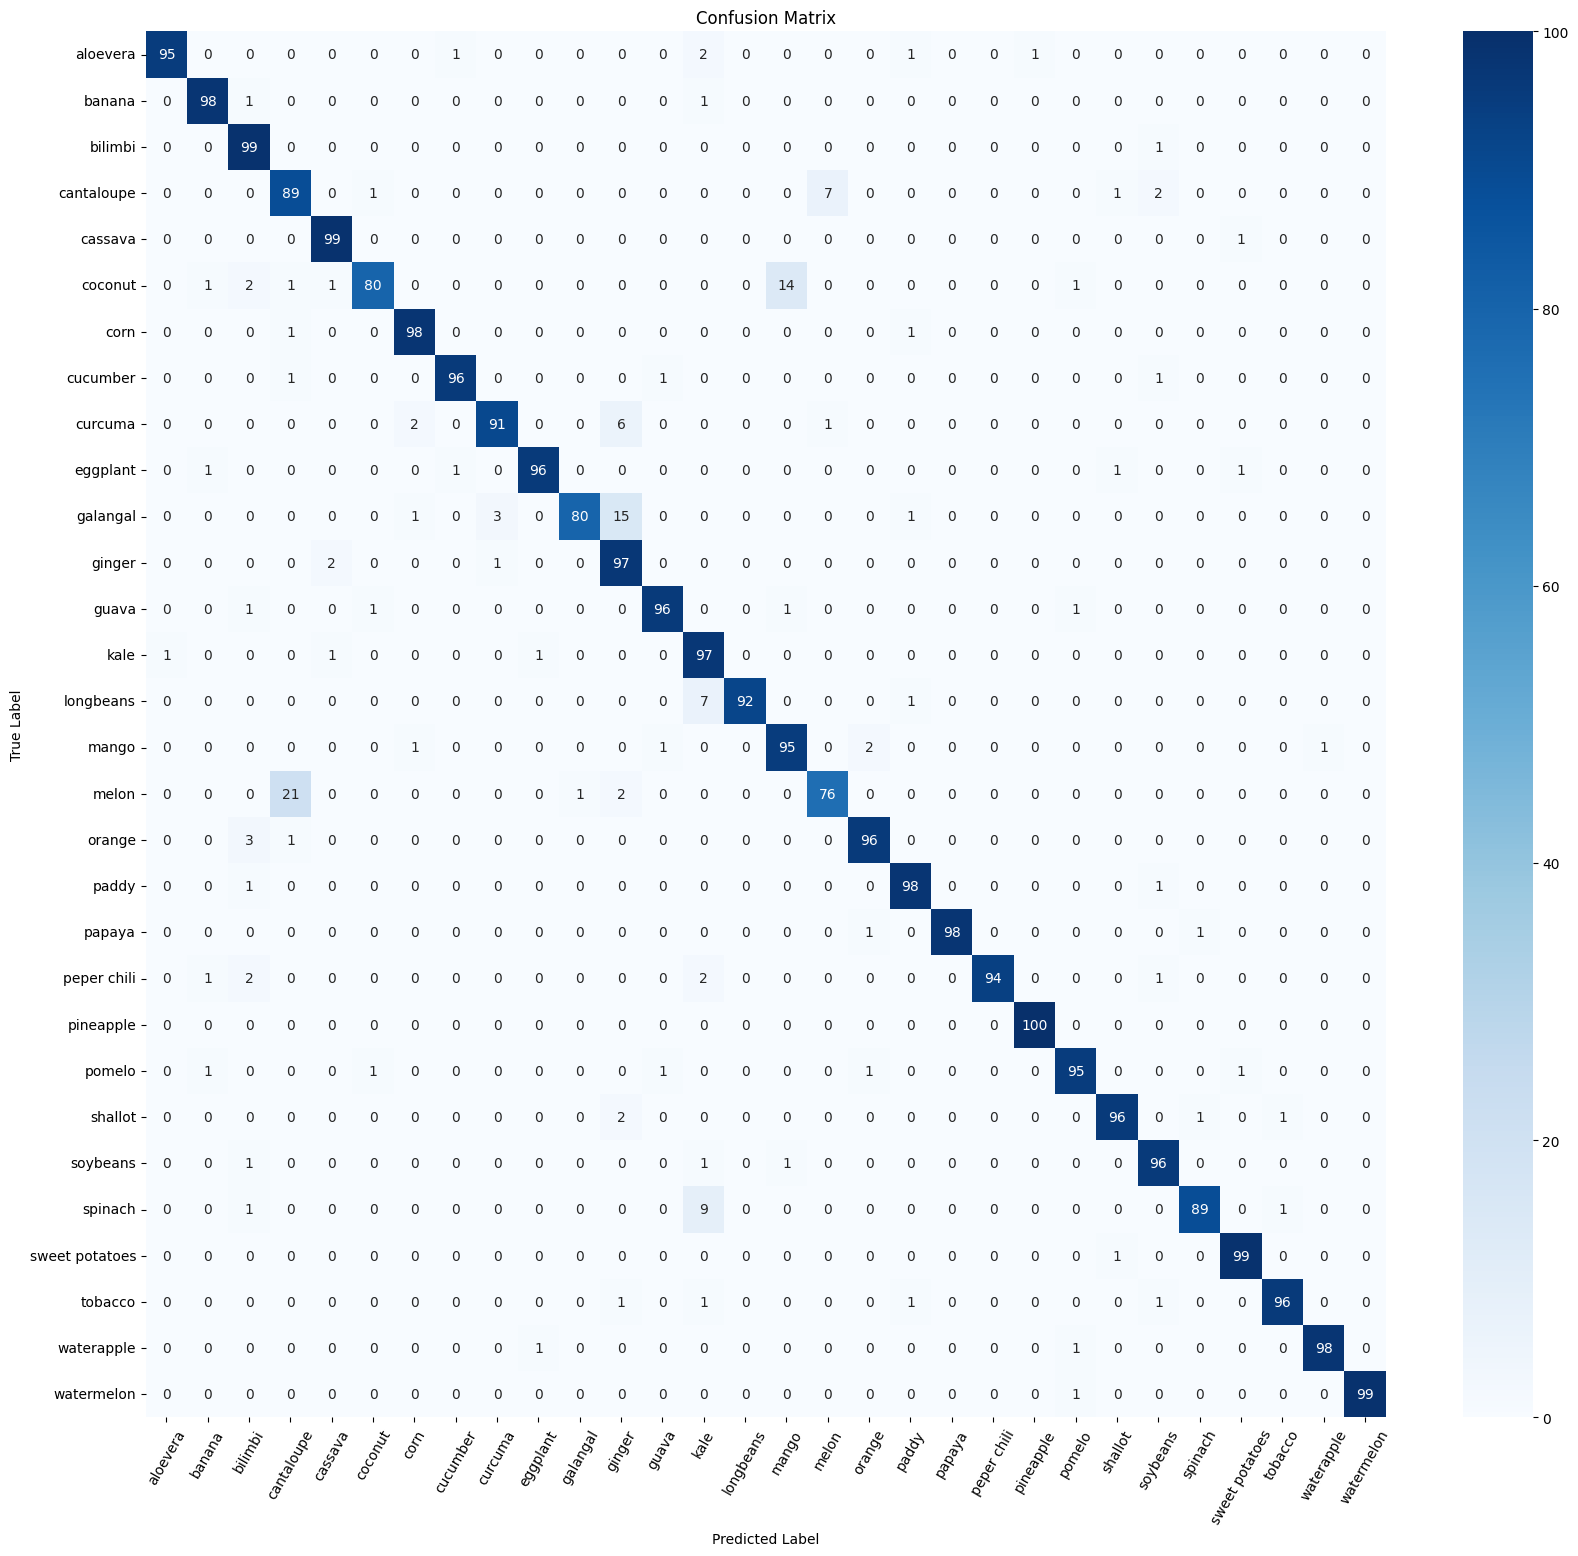

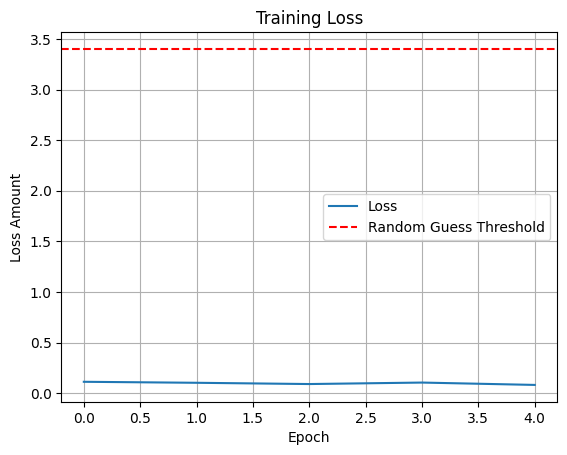

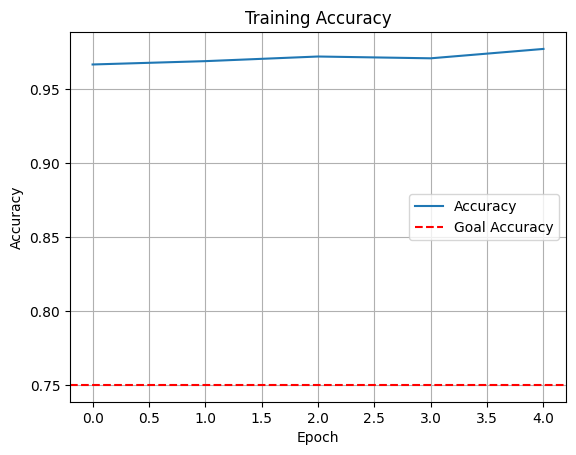

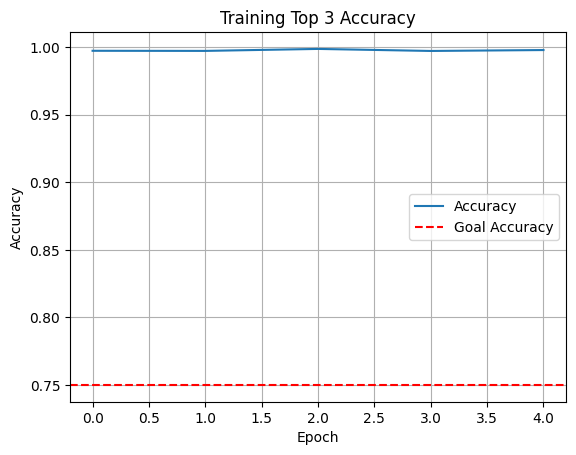

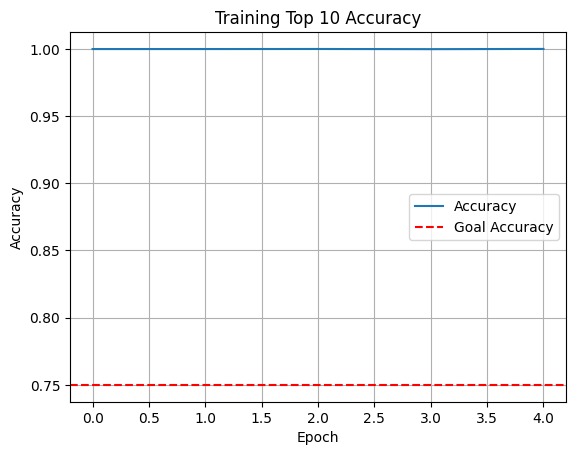

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        320 │ mask_input[0][0]

 Total params: 21,455,132 (81.84 MB)

 Trainable params: 476,766 (1.82 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 953,534 (3.64 MB)

In [25]:
#Showed signs that we could continue training past 10 epochs
dual_model_best.model.load_weights("adative_best_plant_model.keras")
adaptive_segmentation_results = dual_model_best.trainModel(adaptive_train_dual, epochs=5, val_data=adaptive_val_dual)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(adaptive_test_dual)
class_names = training_data.class_names

training_loss = adaptive_segmentation_results.history['loss']
training_accuracy = adaptive_segmentation_results.history["accuracy"]
top_3_accuracy = adaptive_segmentation_results.history["top_3_accuracy"]
top_10_accuracy = adaptive_segmentation_results.history['top_10_accuracy']

precision, recall, fscore, support = Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [26]:
#extended model
dual_model_best.model.save("ext_adative_best_plant_model.keras")